In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

In [49]:
# import DiCE
import dice_ml
from dice_ml.utils import helpers # helper functions

In [50]:
df = pd.read_csv('train.csv')
df

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [51]:
# show ratio of survived and non-survived
print(df['survived'].value_counts())
df.info()

0    549
1    342
Name: survived, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  891 non-null    int64  
 1   pclass    891 non-null    int64  
 2   name      891 non-null    object 
 3   sex       891 non-null    object 
 4   age       714 non-null    float64
 5   sibsp     891 non-null    int64  
 6   parch     891 non-null    int64  
 7   ticket    891 non-null    object 
 8   fare      891 non-null    float64
 9   cabin     204 non-null    object 
 10  embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


In [52]:
# feature engineering for name column
df['title'] = df['name'].str.extract('([A-Za-z]+)\.', expand=True)

# replacing some titles with more common ones
mapping = {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Sir': 'Mr',
           'Don': 'Mr', 'Mme': 'Mrs', 'Jonkheer': 'Mr', 'Lady': 'Mrs',
           'Capt': 'Mr', 'Countess': 'Mrs', 'Ms': 'Miss', 'Dona': 'Mrs'}
df.replace({'title': mapping}, inplace=True)
df['title'].value_counts()

Mr        525
Miss      185
Mrs       128
Master     40
Dr          7
Rev         6
Name: title, dtype: int64

Dict for median age for titles: {'Dr': 46.5, 'Master': 3.5, 'Miss': 21.0, 'Mr': 30.0, 'Mrs': 35.0, 'Rev': 46.5}


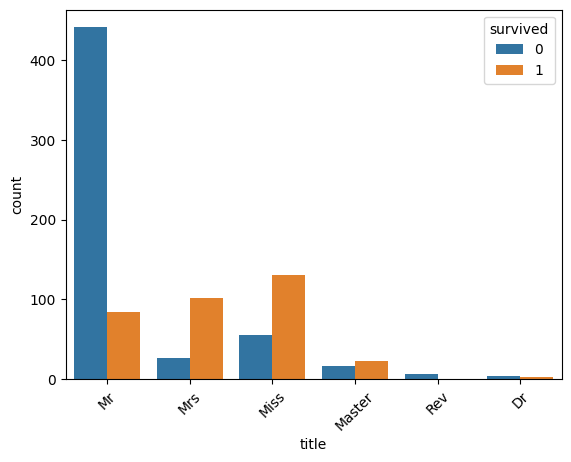

In [53]:
# impute missing age values using median of title groups
title_ages = dict(df.groupby('title')['age'].median())
print("Dict for median age for titles: {}".format(title_ages))

# create a column of the average ages
df['age_med'] = df['title'].apply(lambda x: title_ages[x])

# replace all missing ages with the value in this column
df['age'].fillna(df['age_med'], inplace=True, )
del df['age_med']

# Visualize survival rates of titles
sns.countplot(x='title', data=df, hue='survived')
plt.xticks(rotation=45)
plt.show()

In [54]:
# impute missing fare values using median of pclass groups
class_fares = dict(df.groupby('pclass')['fare'].median())
print("Dict for median fare for pclasses: {}".format(class_fares))

# create a column of the average fares
df['fare_med'] = df['pclass'].apply(lambda x: class_fares[x])

# replace all missing fares with the value in this column
df['fare'].fillna(df['fare_med'], inplace=True, )
del df['fare_med']

Dict for median fare for pclasses: {1: 60.287499999999994, 2: 14.25, 3: 8.05}


In [55]:
# feature engineering for embarked and family_zize, dropped cabin, name, and ticket
df['embarked'].fillna(method='backfill', inplace=True)
df['family_size'] = df['parch'] + df['sibsp']
df.drop(['cabin', 'name', 'ticket'], axis=1, inplace=True)

In [56]:
target = df["survived"]
sess = tf.compat.v1.InteractiveSession()
train_dataset, test_dataset, y_train, y_test = train_test_split(df,
                                    target,
                                    test_size=0.2,
                                    random_state=0,
                                    stratify=target)

x_train = train_dataset.drop('survived', axis=1)
x_test = test_dataset.drop('survived', axis=1)
train_dataset.head()

C:\Users\pei4b\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\client\session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


,survived,pclass,sex,age,sibsp,parch,fare,embarked,title,family_size
502,0,3,female,21.0,0,0,7.6292,Q,Miss,0
464,0,3,male,30.0,0,0,8.0500,S,Mr,0
198,1,3,female,21.0,0,0,7.7500,Q,Miss,0
765,1,1,female,51.0,1,0,77.9583,S,Mrs,1
421,0,3,male,21.0,0,0,7.7333,Q,Mr,0


In [57]:
d = dice_ml.Data(dataframe=train_dataset, continuous_features=['age', 'fare'], outcome_name='survived')

In [58]:
numerical = ['age', 'fare']
categorical = x_train.columns.difference(numerical)

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

transformations = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', transformations),
                      ('classifier', RandomForestClassifier())])
model = clf.fit(x_train, y_train)

In [70]:
# Using sklearn backend
m = dice_ml.Model(model=model, backend='sklearn')
# Using method=random for generating CFs
exp = dice_ml.Dice(d, m, method='kdtree')

In [71]:
factual_sample = x_test[0:1]
e1 = exp.generate_counterfactuals(factual_sample, total_CFs=10, desired_class="opposite")
e1.visualize_as_dataframe(show_only_changes=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.45s/it]

Query instance (original outcome : 0)


,pclass,sex,age,sibsp,parch,fare,embarked,title,family_size,survived
0,3,male,40.5,0,2,14.5,S,Mr,2,0



Diverse Counterfactual set (new outcome: 1)


,pclass,sex,age,sibsp,parch,fare,embarked,title,family_size,survived
254,-,female,40.9,-,-,20.21,-,Mrs,-,1
140,-,female,35.0,-,-,15.0,C,Mrs,-,1
503,-,female,37.0,-,0,9.59,-,Miss,0,1
161,2,female,41.0,-,0,14.99,-,Mrs,0,1
346,2,female,41.0,-,0,15.01,-,Miss,0,1
865,2,female,41.0,-,0,15.01,-,Mrs,0,1
357,2,female,41.0,-,0,15.01,-,Miss,0,1
255,-,female,29.0,-,-,15.0,C,Mrs,-,1
279,-,female,35.0,1,1,20.25,-,Mrs,-,1
415,-,female,35.0,-,0,8.05,-,Mrs,0,1


In [61]:
imp = exp.local_feature_importance(factual_sample, cf_examples_list=e1.cf_examples_list)
print(imp.local_importance)

[{'sibsp': 1.0, 'parch': 1.0, 'title': 1.0, 'family_size': 1.0, 'age': 1.0, 'fare': 1.0, 'pclass': 0.9, 'embarked': 0.2, 'sex': 0.1}]


In [62]:
cobj = exp.global_feature_importance(x_test[0:10], total_CFs=10, posthoc_sparsity_param=None)
print(cobj.summary_importance)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.37it/s]

{'parch': 1.0, 'sibsp': 0.99, 'family_size': 0.98, 'pclass': 0.91, 'sex': 0.65, 'title': 0.43, 'age': 0.28, 'embarked': 0.22, 'fare': 0.16}


In [129]:
# generate counterfactuals
factual_sample = x_test[155:156]
dice_exp = exp.generate_counterfactuals(factual_sample, total_CFs=8, desired_class="opposite", proximity_weight=2, diversity_weight=2,
                                        features_to_vary=['pclass','age','fare','embarked']
                                       )

dice_exp.visualize_as_dataframe(show_only_changes=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.41it/s]

Query instance (original outcome : 0)


,pclass,sex,age,sibsp,parch,fare,embarked,title,family_size,survived
0,1,male,4.0,0,2,81.858299,S,Master,2,0



Diverse Counterfactual set (new outcome: 1)


,pclass,sex,age,sibsp,parch,fare,embarked,title,family_size,survived
827,2,-,-,-,-,37.0,C,-,-,1


In [ ]:
x_test[41:42]